## Bike Sharing Problem - Model building and inference

This notebook documents the analysis and model development for the Bike Sharing Dataset.

$\bf{Goal}$: To goal is to build a predictive model for the number of bike rides an hour based on time of year and weather. In particular we are interested in predicting the number of rides, cnt.

The characteristics of the given problem are

- Regression: The target variable is a quantity.
- Small dataset: Less than 20K samples.
- Few features should be important.
    * The correlation matrix indicates that a few features contain the information to predict the target variable.

It contains the following steps:
- Overview metrics
- Model building
- Model Selection
  * Linear Regession
  * Tree-based Ensemble Regression
  * Feature importance
- Model evaluation

In [2]:
## Loading required package
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import scipy.stats as stats

# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

# Sklearn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Sklearn untility functions
from sklearn.model_selection import train_test_split

# XGBoost, Catboost, and LightGBM models
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
import lightgbm as lgbm

# Beautify evaluation tables
from prettytable import PrettyTable

np.random.seed(42)

In [3]:
# File path 
base_dir = '/Users/chrisjcc/Downloads/'
data_path = base_dir + 'hour.csv'

# Load data
data = pd.read_csv(data_path) 

In [4]:
# Quick check of proper loading of dataset
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Data Preparation

This step involves cleaning the data, dropping unwanted columns, converting the categorical variables to numeric, and finally splitting of training data into train and validation sets.

In [5]:
# Preprocessing: Renaming columns names to more readable names
data.rename(columns={'instant':'rec_id',
                     'dteday':'datetime',
                     'holiday':'is_holiday',
                     'workingday':'is_workingday',
                     'weathersit':'weather_condition',
                     'hum':'humidity',
                     'mnth':'month',
                     'cnt':'total_count',
                     'hr':'hour',
                     'yr':'year',
                    },inplace=True)

In [6]:
# Setting proper data types

# date time conversion
data['datetime'] = pd.to_datetime(data.datetime)

# categorical fetures
data['season']     = data.season.astype('category')
data['is_holiday'] = data.is_holiday.astype('category')
data['weekday']    = data.weekday.astype('category')
data['weather_condition'] = data.weather_condition.astype('category')
data['is_workingday']     = data.is_workingday.astype('category')
data['month'] = data.month.astype('category')
data['hour']  = data.hour.astype('category')
data['year']  = data.year.astype('category')

### Split data into training and test sets

Each observation can either be used for building a model or evaluating a model, not both. For this reason we must perform a train/test partition of the main dataset be used for model training and evaluation, respectively. We'll use this set to make predictions and compare them with the actual number of bike riders.

In [7]:
# Divide the dataset into training and testing sets (randomly and stratified)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:-3],
                                                    data.iloc[:,-1],
                                                    test_size=0.33,
                                                    stratify=None,
                                                    random_state=42)

In [8]:
# Training data used for model developement
X_train.reset_index(inplace=True)
y_train = y_train.reset_index()

# Set aside a hold-out test data used for final model performance
X_test.reset_index(inplace=True)
y_test = y_test.reset_index()
print("We have %d training samples and %d test samples." % (y_train['total_count'].count(), 
                                                            y_test['total_count'].count()))

We have 11643 training samples and 5736 test samples.


### Baseline Model

We take as a baseline model a model that does not depend applying any machine learning techniques. We will use Mean Absoluate Deivation (MAD) as the evaluation metric for model performance.


#### Evaluation metric

The Mean Absolute Deviation (MAD) helps determine whether the set's mean is a useful indicator of the values within the set. The larger the MAD, the less relevant is the mean as an indicator of the values within the set. MAD, the greater variability there is in the data (the data is more spread out). MAE is more robust to outlier than is MSE. MAE assigns equal weight to the data whereas MSE emphasizes the extremes. Since the errors are squared before they are averaged, the Root Mean Square Error (RMSE) gives a relatively high weight to large errors. This means the RMSE is most useful when large errors are particularly undesirable.

The MAE and the RMSE can be used together to diagnose the variation in the errors in a set of forecasts. The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. If the RMSE=MAE, then all the errors are of the same magnitude.Root RMSE basically tells you to avoid models that give you occasional large errors. And MSE = Bias^2 + Variance.

Depending on how we want your model to treat outliers, or extreme values, in our data, we may want to bring more attention to these outliers or downplay them. The issue of outliers can play a major role in which error metric we use.


MAE vs MSE
Even though MAE is more robust (less sensitive to outliers) than MSE but this doesn’t mean it is always better to use MAE. The following questions help you to decide:

1. Do you have outliers in the data? Use MAE.

2. Are you sure they are outliers? Use MAE.

3. Or they are just unexpected values we should still care about? Use MSE.

In [9]:
# Average bike usage from training data
avg_bike_usuage = round(np.mean(y_train['total_count']), 2)
baseline_pred   = np.repeat(avg_bike_usuage, y_test.shape[0])

# Evaluate baseline model
baseline_mae = mean_absolute_error(baseline_pred, y_test['total_count'])

print("Basline Mean Absolute Deviation of Validation data: %.2f" % baseline_mae)

Basline Mean Absolute Deviation of Validation data: 141.78


We will predict the average bike usage. This resulted in an MAD of 141.78. So any model we build should have an MAD lower than 141.78.

### Model Building

#### Without Feature Engineering

In the following section we will compare linear regresssion/SGD based algorithms against tree-ensemble based methods to see which group performs best out of the box using mean absolute devaition metric evaluation. For linear ression modeling requires converting the cateogrical features into numeric featuers, while tree-based models do not need to transform them or can handle that step internally.

In [10]:
# Defiting One-hot-encoding and Label-encoding transformation function
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
column.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [11]:
# Encoding all the categorical features
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month',#'year'
                ]

# though we have transformed all categoricals into their one-hot encodings, note that ordinal
# attributes such as hour, weekday, and so on do not require such encoding.
numeric_feature_cols = ['temp','humidity','windspeed', 'atemp',
                        'hour','weekday','month',#'year'
                       ]
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [12]:
# Train dataset
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X_train,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})


feature_df_list  = [X_train[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Train dataset shape::{}".format(train_df_new.shape))
print(train_df_new.head())

Train dataset shape::(11643, 19)
   temp  humidity  windspeed   atemp hour weekday month  season_1  season_2  \
0  0.64      0.65     0.1940  0.6061    0       5     9       0.0       0.0   
1  0.50      0.45     0.2239  0.4848   13       2     3       0.0       1.0   
2  0.86      0.47     0.5224  0.8030   12       0     8       0.0       0.0   
3  0.30      0.61     0.0000  0.3333    2       3     2       1.0       0.0   
4  0.54      0.19     0.4179  0.5152   17       6     4       0.0       1.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       1.0       0.0           1.0           0.0                  1.0   
1       0.0       0.0           1.0           0.0                  1.0   
2       1.0       0.0           1.0           0.0                  1.0   
3       0.0       0.0           1.0           0.0                  1.0   
4       0.0       0.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  we

In [13]:
# Test dataset
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,le,ohe,col_name),'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Test dataset shape::{}".format(test_df_new.shape))
print(test_df_new.head())

Test dataset shape::(5736, 19)
   temp  humidity  windspeed   atemp hour weekday month  season_1  season_2  \
0  0.80      0.27     0.1940  0.6970   19       6     6       0.0       0.0   
1  0.24      0.41     0.2239  0.2273   20       1     1       1.0       0.0   
2  0.32      0.66     0.2836  0.3030    2       5    10       0.0       0.0   
3  0.78      0.52     0.3582  0.7121   19       2     5       0.0       1.0   
4  0.26      0.56     0.3881  0.2273    0       4     1       1.0       0.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       1.0       0.0           1.0           0.0                  1.0   
1       0.0       0.0           0.0           1.0                  1.0   
2       0.0       1.0           1.0           0.0                  1.0   
3       0.0       0.0           1.0           0.0                  1.0   
4       0.0       0.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  weat

In [14]:
# transform train dataset
X_train = train_df_new
y_train = y_train.total_count.values.reshape(-1,1)

In [15]:
# transform test dataset
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

In [16]:
table = PrettyTable()
table.field_names = ["Model", "Dataset", "MAE", "MSE", "R² score", "Variance"]

#### Linear based methods

In [17]:
# Model selection
models = [
    # specify the hyper-parameters 
    LinearRegression(),
    Lasso(alpha=0.1),
    ElasticNet(random_state=0),
    Ridge(alpha=.5),
    SGDRegressor(max_iter=1000, tol=1e-3),
]

In [18]:
%%time
for model in models:
    dataset = 'training'
    
    # Model training
    model.fit(X_train, y_train)
    
    # Make prediction on test and training data set
    y_pred = model.predict(X_test)
    y_res  = model.predict(X_train)

    # Evaluate model performance (for shortness of time will only CV MAE)
    mse = mean_squared_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    # Cross-Validated Mean Absolute Deviation regression loss
    mae = -np.mean(cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1, scoring="neg_mean_absolute_error"))

    
    
    variance  = abs(mean_absolute_error(y_train, y_res) - mae)
    
    print("%.2f" % mean_absolute_error(y_train, y_res))

    
    table.add_row([type(model).__name__, 
                   dataset,
                   format(mae, '.2f'),
                   format(mse, '.2f'),   
                   format(score, '.2f'),
                   format(variance, '.2f')
                  ],
                 )
    
print(table)

108.49
108.47
119.80
108.49
107.75
+------------------+----------+--------+----------+----------+----------+
|      Model       | Dataset  |  MAE   |   MSE    | R² score | Variance |
+------------------+----------+--------+----------+----------+----------+
| LinearRegression | training | 108.73 | 20413.31 |   0.36   |   0.24   |
|      Lasso       | training | 108.70 | 20420.14 |   0.36   |   0.23   |
|    ElasticNet    | training | 119.86 | 24493.28 |   0.23   |   0.06   |
|      Ridge       | training | 108.73 | 20413.26 |   0.36   |   0.23   |
|   SGDRegressor   | training | 106.09 | 20657.63 |   0.35   |   1.65   |
+------------------+----------+--------+----------+----------+----------+
CPU times: user 1.17 s, sys: 1.17 s, total: 2.34 s
Wall time: 4.97 s


Table summary of model's performance across various evaluation metrics typically used in regression problems. For our purposes the most import one being the Mean Absolute Deviation (MAE). The RMSE-MAE difference isn't large enough to indicate the presence of very large errors. If RMSE>MAE, then there is variation in the errors.

```
+------------------+----------+--------+----------+----------+----------+
|      Model       | Dataset  |  MAE   |   MSE    | R² score | Variance |
+------------------+----------+--------+----------+----------+----------+
| LinearRegression | training | 108.73 | 20413.31 |   0.36   |   0.24   |
|      Lasso       | training | 108.70 | 20420.14 |   0.36   |   0.23   |
|    ElasticNet    | training | 119.86 | 24493.28 |   0.23   |   0.06   |
|      Ridge       | training | 108.73 | 20413.26 |   0.36   |   0.23   |
|   SGDRegressor   | training | 106.68 | 20657.63 |   0.35   |   1.07   |
+------------------+----------+--------+----------+----------+----------+
```

The test MAD for Linear Regression-based/SGD model range between 108-119, and the training was 107-119, which provides confidence that's no problem of overfitting is there's not gap between training and test performance range for MAE. These models are an improvement on the baseline prediction which had mean asolute error of 141.78. Still, the error rate is very high in this linear regression models, though the variance is relatively low (0.23-16.86). As we also so in the other metrics they have quite high values an R² score closer to 1. is and indicator of better performance.

In [19]:
# Cross-validate model's performance using validation dataset
predicted = cross_val_predict(Lasso(alpha=0.1), 
                              X_train, y_train, 
                              cv=3)

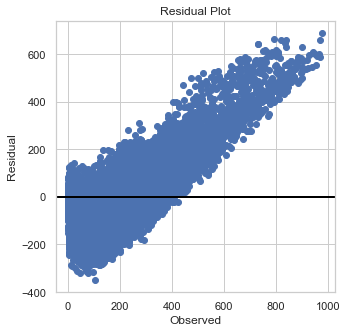

In [20]:
# Analysing Residuals in model's predictinos
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_train-predicted.reshape(-1,1))
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
ax.set_title('Residual Plot')
plt.show()

This residual plots shows a linear trend across observations. 

#### Ensemble tree-based algorithms

As these tree-based methods have build in handling of categorical feature we will need to re-load data that are not one-hot-encoded.

In [78]:
# Divide the dataset into training and testing sets (randomly and stratified)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:-3],
                                                    data.iloc[:,-1],
                                                    test_size=0.33,
                                                    stratify=None,
                                                    random_state=42)
# Training data used for model developement
X_train.reset_index(inplace=True)
y_train = y_train.reset_index()

# Set aside a hold-out test data used for final model performance
X_test.reset_index(inplace=True)
y_test = y_test.reset_index()
print("We have %d training samples and %d test samples." % (y_train['total_count'].count(), 
                                                            y_test['total_count'].count()))

We have 11643 training samples and 5736 test samples.


In [79]:
# transform train dataset
y_train = y_train['total_count']

X_train = X_train[['season', 'month','hour','is_holiday','weekday','is_workingday', #'year'
                   'weather_condition','temp','atemp','humidity','windspeed']]

# transform test dataset
y_test = y_test['total_count']
X_test = X_test[['season','month','hour','is_holiday','weekday','is_workingday', #'year'
                 'weather_condition','temp','atemp','humidity','windspeed']]

### Model building, selection, and evaluation

In [86]:
# Model selection
models = [
    # specify the training parameters 
    CatBoostRegressor(loss_function='MAE', #'RMSE', 
                      max_depth=3, #None
                      cat_features=cat_attr_list,
                      random_state=42,
                      #one_hot_max_size=10,
                      verbose=False
                     ),
    lgbm.sklearn.LGBMRegressor(boosting_type='gbdt', 
                               objective='regression',
                               min_child_samples=10,  
                               max_depth=-1,
                               categorical_feature=cat_attr_list,
                               nthread=-1,
                               random_state=42,
                               silent=False
                              ),
    GradientBoostingRegressor(max_depth=3, 
                              min_samples_leaf=10, 
                              random_state=42),
    AdaBoostRegressor(DecisionTreeRegressor(max_depth=3, #None 
                                            min_samples_leaf=10,
                                            criterion='mae',
                                           ),
                      random_state=42),
    RandomForestRegressor(criterion='mae', 
                          min_samples_leaf=10,
                          max_depth=None, # If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
                          random_state=42,
                          n_jobs=-1,
                         ),
    # Requires OHE the input data before training
    #XGBClassifier(max_depth=3, #None
    #              objective='count:poisson', #'reg:linear', 
    #              min_samples_leaf=10,
    #              random_state=42),
]

In [87]:
# Configure the the evaluation metrics of intereset (Mean Absolute Devation is prirmery)
table = PrettyTable()
table.field_names = ["Model", "Dataset", "MAE", "MSE", "R² score", "Variance"]

In [88]:
%%time
for model in models:
    dataset = 'training'
    
    # Model training
    model.fit(X_train, y_train, 
              #verbose=False # does not work for all algorithms
             )
    
    # Make prediction on test and training data set
    y_pred = model.predict(X_test)
    y_res  = model.predict(X_train)

    # Evaluate model performance (for shortness of time will only CV MAE)
    mse = mean_squared_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    # Cross-Validated Mean Absolute Deviation regression loss
    mae = -np.mean(cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1,
                                   scoring="neg_mean_absolute_error"))    
    
    variance  = abs(mean_absolute_error(y_train, y_res) - mae)
    
    print("Training MAE:")
    print("%.2f" % mean_absolute_error(y_train, y_res))

    
    table.add_row([type(model).__name__, 
                   dataset,
                   format(mae, '.2f'),
                   format(mse, '.2f'),   
                   format(score, '.2f'),
                   format(variance, '.2f')
                  ],
                 )
    
print(table)

Training MAE:
55.69
Training MAE:
38.69
Training MAE:
56.78
Training MAE:
74.19
Training MAE:
41.07
+---------------------------+----------+-------+---------+----------+----------+
|           Model           | Dataset  |  MAE  |   MSE   | R² score | Variance |
+---------------------------+----------+-------+---------+----------+----------+
|     CatBoostRegressor     | training | 57.66 | 7135.36 |   0.78   |   1.96   |
|       LGBMRegressor       | training | 46.81 | 4197.48 |   0.87   |   8.12   |
| GradientBoostingRegressor | training | 58.60 | 6593.21 |   0.79   |   1.82   |
|     AdaBoostRegressor     | training | 73.08 | 9057.61 |   0.72   |   1.11   |
|   RandomForestRegressor   | training | 50.10 | 5159.19 |   0.84   |   9.03   |
+---------------------------+----------+-------+---------+----------+----------+
CPU times: user 4min 10s, sys: 2.25 s, total: 4min 12s
Wall time: 5min 32s


Table summary of model's performance across various evaluation metrics typically used in regression problems. For our purposes the most import one being the Mean Absolute Deviation (MAE).

```
+---------------------------+----------+-------+---------+----------+----------+
|           Model           | Dataset  |  MAE  |   MSE   | R² score | Variance |
+---------------------------+----------+-------+---------+----------+----------+
|     CatBoostRegressor     | training | 55.60 | 6356.81 |   0.80   |   3.37   |
|       LGBMRegressor       | training | 46.81 | 4197.48 |   0.87   |   8.12   |
| GradientBoostingRegressor | training | 58.60 | 6593.21 |   0.79   |   1.82   |
|     AdaBoostRegressor     | training | 73.08 | 9057.61 |   0.72   |   1.11   |
|   RandomForestRegressor   | training | 50.10 | 5159.19 |   0.84   |   9.03   |
+---------------------------+----------+-------+---------+----------+----------+
```


From the table above LGBMRegressor performs best with MAE of 46.81, outperforming linear/sgd-base regression algorithms, but with similar performance as RandomForestRegressor if we factor in the spread in variance of 8.12 on the model's prediction (possibly reduce overtraining using early-stoping method). For this reason we will selected the LGBMRegressor algorithms as our choice of model for further tuning using Bayesian Optimization discussed in the model optimization notebook. Training MAE evaluation ranges between 38.69 - 74.19. 

LightGBM uses a novel technique of Gradient-based One-Side Sampling (GOSS) to filter out the data instances for finding a split value while XGBoost uses pre-sorted algorithm & Histogram-based algorithm (i.e. discrete bins and uses these bins to find the split value of histogram) for computing the best split. 

In [56]:
# Cross-validate model prediction
predicted = cross_val_predict(
    lgbm.sklearn.LGBMRegressor(boosting_type='gbdt', 
                               objective='regression',
                               min_child_samples=10,  
                               max_depth=-1,
                               categorical_feature=cat_attr_list,
                               nthread=-1,
                               random_state=42,
                               silent=False
                              ), 
    X_train, y_train, cv=3)

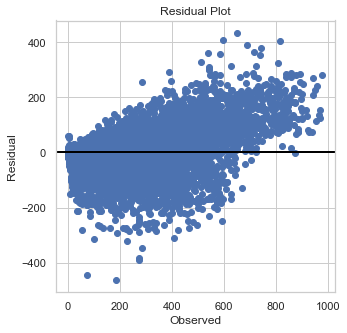

In [57]:
# Analysing Residuals in model's predictinos
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(y_train, y_train-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
ax.set_title('Residual Plot')
plt.show()

From this residual plot we observe a upward linear trend. Positive values for the residual (on the y-axis) mean the prediction was too low, and negative values mean the prediction was too high; 0 means the guess was exactly correct. These plots aren’t evenly distributed vertically, or they have an outlier, or they have a clear shape to them. We detected a clear pattern or trend in your residuals, then our model has room for improvement.

In [58]:
# Alternatively, we train model based on training data and produce residual plot based on test dataset
model = lgbm.sklearn.LGBMRegressor(boosting_type='gbdt', 
                                   objective='regression',
                                   min_child_samples=10,  
                                   max_depth=-1,
                                   categorical_feature=cat_attr_list,
                                   nthread=-1,
                                   random_state=42,
                                   silent=False
                                  )
model.fit(X_train, y_train)
y_pred = model.predict(X_test) 

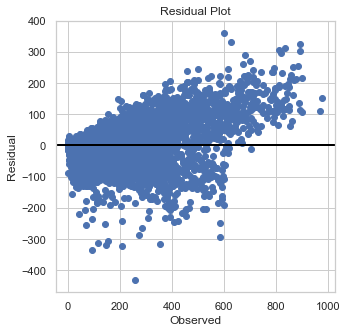

In [59]:
# Analysing Residuals in model's predictinos
fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, y_test-y_pred)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
ax.set_title('Residual Plot')
plt.show()

### Model Evaluation Summary

After looking at the performance across all the models, we will decide to select a tree-ensemble based algorithm, in particular the CatBoostRegressor algorith as it has great performance with a mean absoluate deviation of about 31.5 and a standar deviation of less than 4.0. We select this model over LGBMRegressor with a mean absolute devation of 27.98 although it has a better performance it has a larger variance of almost 6.0. Both models perform similarly if we factor in the level of varinace, so we make the conservative choice of going with the one with slightly lower varinace as it stand a better chance to perform better in production making predictions on new unseen data.

We can next try some feature engineering in order to possible improve model performance.

### Feagure Engineering

We try to build new features that we can employ in our predictive modeling step, relating temperature and weather information together and see if generates model performance improvement above baseline (without new features). Feature engineering involves turning available data-features into more useful variables that can help us predict our outcome.

- Extracting the week number from the date. The date itself, in the format provided, isn’t something that can be processed in our algorithms. From this date, however, we can extract the week number (for that particular using features based on temparature) and use that variable as a predictor for the usage count.

In [69]:
temp_diff = data.atemp - data.temp
ratio_cnt = data.casual / data.registered
heat      = data.atemp * data.humidity

In [70]:
features = pd.concat([#ratio_cnt,
                      temp_diff, heat,
                      data.total_count, data.season, #data.year, 
                      data.month, data.hour, data.is_holiday,
                      data.weekday, data.is_workingday, data.weather_condition, data.windspeed
                     ],
                     axis=1,
                     join='outer',
                     ignore_index=True)

In [ ]:
features.rename(columns={0: "ratio_cnt",
                         1: "temp_diff", 
                         2: "heat", 
                         3: "total_count",
                         4: "season", #5: "year", 
                         5: "month", 6: "hour", 
                         7: "is_holiday", 
                         8: "weekday",
                         9: "is_workingday", 
                         10: "weather_condition", 
                         11: "windspeed"
                        }, inplace=True)
features.head()

In [71]:
features.rename(columns={
                         0: "temp_diff", 
                         1: "heat", 
                         2: "total_count",
                         3: "season", #5: "year", 
                         4: "month", 6: "hour", 
                         5: "is_holiday", 
                         6: "weekday",
                         7: "is_workingday", 
                         9: "weather_condition", 
                         10: "windspeed"
                        }, inplace=True)
features.head()

,temp_diff,heat,total_count,season,month,is_holiday,weekday,is_workingday,8,weather_condition,windspeed
0,0.0479,0.233199,16,1,1,0,0,6,0,1,0.0
1,0.0527,0.218160,40,1,1,1,0,6,0,1,0.0
2,0.0527,0.218160,32,1,1,2,0,6,0,1,0.0
3,0.0479,0.215925,13,1,1,3,0,6,0,1,0.0
4,0.0479,0.215925,1,1,1,4,0,6,0,1,0.0


In [72]:
# Divide the dataset into training and testing sets (randomly and stratified)
x_train, x_test, y_train, y_test = train_test_split(features.drop('total_count', axis=1),
                                                    features['total_count'],
                                                    test_size=0.33,
                                                    stratify=None,
                                                    random_state=42)
# Training data used for model developement
x_train.reset_index(inplace=True)
y_train = y_train.reset_index()

# Set aside a hold-out test data used for final model performance
x_test.reset_index(inplace=True)
y_test = y_test.reset_index()

y_train = y_train['total_count']
y_test = y_test['total_count']

In [73]:
# Setup estimator
lgbmr = lgbm.sklearn.LGBMRegressor(boosting_type='gbdt', 
                               objective='regression',
                               min_child_samples=10,  
                               max_depth=-1,
                               categorical_feature=cat_attr_list,
                               nthread=-1,
                               random_state=42
                              )

In [74]:
# Train model
lgbmr.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt',
       categorical_feature=['season', 'is_holiday', 'weather_condition', 'is_workingday', 'hour', 'weekday', 'month'],
       class_weight=None, colsample_bytree=1.0, importance_type='split',
       learning_rate=0.1, max_depth=-1, min_child_samples=10,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, nthread=-1, num_leaves=31, objective='regression',
       random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [75]:
y_pred = lgbmr.predict(x_test)
lgbm_mae = mean_absolute_error(y_pred, y_test)
lgbm_train_mae = mean_absolute_error(lgbmr.predict(x_train), y_train)
lgbm_variance = abs(lgbm_train_mae - lgbm_mae)

In [76]:
table = PrettyTable()
table.field_names = ["Model", "Mean Absolute Deviation"]

In [77]:
# Evaluate model performance using CV Mean absolute error regression loss
mae_cv = -np.mean(cross_val_score(lgbmr, x_train, y_train, cv=3, n_jobs=-1, scoring="neg_mean_absolute_error"))    

table.add_row([type(lgbmr).__name__, 
               format(mae_cv, '.2f'), 
               ])

print(table)

+---------------+-------------------------+
|     Model     | Mean Absolute Deviation |
+---------------+-------------------------+
| LGBMRegressor |          30.02          |
+---------------+-------------------------+


The MAD for LGBMRegressor model was 30.02 on the test dataset. This model train on a dataset based on engineered features did performe better compared to the non-featured engineer modeling. We can conclude that including these specific engineared features as opposed to the raw feature values can benifit the models performance. 

### Conclusion
With these three forms of modelling, there was still not much accuracy in predicting the use of bike sharing per day, using only the data about weather and time of the year (ie, day of week or month/season). When originally plotted the data to observe any clear correlations, we found that a lot of the data is roughly, but not strongly correlated to amount of uses. As a matter of fact, the most important factor was the hour of day, which only had a correlation of about 0.51 (quick calculation performed outside these notebooks). For most of the independent features, there was not a strong connection to the count target with the exception of humidity and temparature related features.

However, while not exactly the most accurate predictions, we did discover a few key points along the way, there was a connection between the amount of uses and weather and type of day. For instance, when felt temperature was high and windspeed was low, more people used the bike sharing method, most likely because it is nicer out and they prefer using bikes over other public transportation methods. As well, we found that the original assumption, that more bikes were used on weekends, to be inaccurate, signaling that people might be using shared bikes during the week to get to and to cummute to and from work or school.

Lastly, in the next notebook we tackle model optimization to train the selected model more robustly resulting in a model that would generalize better to new unseet data.